# Adv. Image Segmentation - Shepherd et al.,

RSGISLib is a set of Python modules which have been developed over the years to support our data processing needs.

The modules provide a set of high level functions, at a similar level to ArcGIS / QGIS toolbox functions or tools in ENVI or Erdas Imagine. The idea is that you can join a number of functions together to undertake your analysis or put those functions within a loop and process a number of input images.

In this tutorial we will look at using the Shepherd et al Segmentation to create image objects from an input image. We will outline each of the steps to do this as well as providing a shorthand example which will take all of the steps for you.

You will learn the following:

- Segment an image to create image objects step-by-step
- Segment an image using a single command

## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Importing Modules

The first step is to import the modules for the analysis we are to undertake:

In [1]:
# RSGISLib Modules
import rsgislib
from rsgislib import segmentation
from rsgislib import imageutils
from rsgislib import imagecalc
from rsgislib import rastergis
from rsgislib import tools
from rsgislib.tools import filetools


# other moduls for viz
import matplotlib
import matplotlib.pyplot as plt
from rsgislib.tools import plotting

/Users/pete/miniforge3/envs/osgeo-env-v1/lib/python3.9/site-packages
['/', 'Users', 'pete', 'miniforge3', 'envs', 'osgeo-env-v1']
/Users/pete/miniforge3/envs/osgeo-env-v1


## Input Image

Image Data Size: 931 x 947


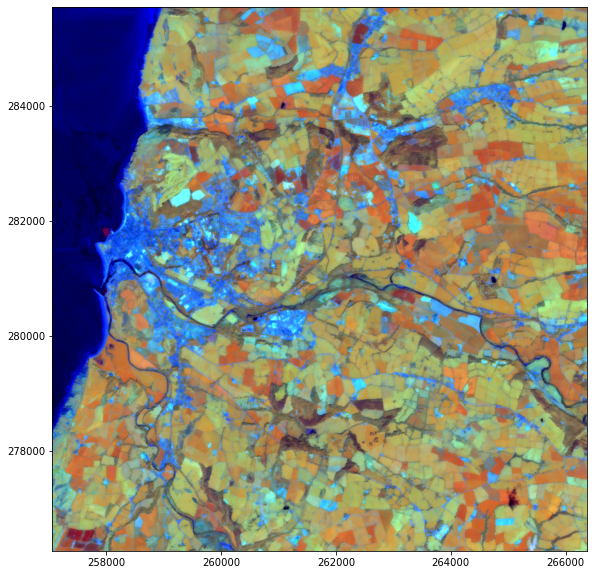

In [2]:
input_img = '../data/sen2_20210527_aber.tif'

### Input image
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we 
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is 
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(input_img, bands=[8,9,3])

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# 2. Segmentation

## Select image bands

Not all image bands are necessarily useful for the segmentation. Here we choose the following bands only:
- blue (1)
- green (2)
- red (3)
- near-infrared (8)
- shortwave-infrared-1 (9)
- shortwave-infrared-2 (10)

In [3]:
input_img_bands = 'sen2_20210527_aber_select.tif'
gdalformat = "GTiff"
gdaltype = rsgislib.TYPE_16UINT
bands_list = [1,2,3,8,9,10]

rsgislib.imageutils.select_img_bands(input_img, input_img_bands, gdalformat, gdaltype, bands_list)

New image width = 931 height = 947 bands = 6



The first stage is to stretch the input image using a linear standard deviation stretch 

In [4]:
# stretch image
strch_file = './sen2_20210527_aber_strch.tif'
save_process_stats = True
img_stretch_stats = './sen2_20210527_stretchstats.txt'
gdalformat = "GTiff"

rsgislib.imageutils.stretch_img(
            input_img_bands,
            strch_file,
            save_process_stats,
            img_stretch_stats,
            True,
            False,
            gdalformat,
            rsgislib.TYPE_8UINT,
            rsgislib.imageutils.STRETCH_LINEARSTDDEV,
            2,)



Band[1] Min = 15 Mean = 48.5252389832 (Std Dev = 19.9321457355) max = 1067
Band[2] Min = 8 Mean = 78.2128592542 (Std Dev = 18.1650242677) max = 1106
Band[3] Min = 11 Mean = 47.7343090729 (Std Dev = 26.2617507701) max = 1111
Band[4] Min = 13 Mean = 448.339837374 (Std Dev = 170.100843825) max = 844
Band[5] Min = 5 Mean = 199.761055603 (Std Dev = 66.6435556283) max = 747
Band[6] Min = 5 Mean = 104.637335154 (Std Dev = 37.8636352173) max = 899
New image width = 931 height = 947 bands = 6



Next we need to add 1 to the stretched file to ensure there are no all zeros (i.e., no data) regions

In [5]:
strch_file_offset = './sen2_20210527_aber_strchoffset.kea'
gdalformat = "GTiff"
gdaltype = rsgislib.TYPE_8UINT
# math expression to add 1 to the image
expression = "b1+1"
rsgislib.imagecalc.image_math(strch_file, strch_file_offset, expression, gdalformat, gdaltype)

New image width = 931 height = 947 bands = 6



And follow this with a valid data mask by making a binary mask based on nodata regions

In [6]:
strch_mask_file = './sen2_20210527_aber_strchmask.tif'
gdalformat = 'GTiff'
# this is a band definition which calls the first image and labels it "b1"
bandMathBands = [rsgislib.imagecalc.BandDefn(band_name="b1", input_img=input_img_bands, img_band=1)]
# An if:else statement to make a binary mask
expression = "b1==0?1:0"
gdaltype = rsgislib.TYPE_8UINT
rsgislib.imagecalc.band_math(strch_mask_file, expression, gdalformat, gdaltype, bandMathBands)

Image: sen2_20210527_aber_select.tif
	 Variable 'b1' is band 1
New image width = 931 height = 947 bands = 1



Now we apply the mask to the stretched image

In [7]:
segment_file = './sen2_20210527_aber_stchd.tif'
gdalformat = 'GTiff'
gdaltype = rsgislib.TYPE_8UINT
nodata = 0
mask_value = 1
rsgislib.imageutils.mask_img(strch_file_offset, strch_mask_file, segment_file, "GTiff", gdaltype, nodata, mask_value,)

New image width = 931 height = 947 bands = 6



One of the primary steps is to create a k-means algorithm to cluster pixels of similar relfectance together

In [8]:
print("Performing KMeans.")
out_matrix_file = './sen2_20210527_aber_kmeansclusters.gmtxt'
# Int which specifies the number of clusters within the
# KMeans clustering (default = 60).
num_clusters = 80
# Maximum iterations for KMeans
km_max_iter = 200
# specify the subsampling of the image for the data used within
# the KMeans (default = 100; 1 == no subsampling).
sampling = 100
# bool to ignore zeroes
ignore_zeroes = True
# specify the degree of change threshold to be met before clustering is stopped
degree_change = 0.0025
# the init clustering method
init_cluster_method = rsgislib.imagecalc.INITCLUSTER_DIAGONAL_FULL_ATTACH

rsgislib.imagecalc.kmeans_clustering(segment_file, out_matrix_file, num_clusters, km_max_iter, sampling, ignore_zeroes, degree_change, init_cluster_method,)

Performing KMeans.
inputImage = ./sen2_20210527_aber_stchd.tif
outputMatrixFile = ./sen2_20210527_aber_kmeansclusters.gmtxt
numClusters = 80
maxNumIterations = 200
subSample = 100
degreeOfChange = 0.00249999994412


The next step is to label the input image pixels with the k-means clustering 

In [9]:
kmeans_file_zones = './sen2_20210527_aber_kmeans.tif'
gdalformat = 'GTiff'
ignore_zeroes = True

rsgislib.segmentation.label_pixels_from_cluster_centres(segment_file, kmeans_file_zones, out_matrix_file, ignore_zeroes, gdalformat)

Ignoring Zeros
Full diag attached.
Subsampling the image to read into memory
Performing clustering
Starting Iterative processing...
Iteration 0 has change 34.4334793091 % of data clump IDs (80 clusters).
Iteration 1 has change 19.0654411316 % of data clump IDs (80 clusters).
Iteration 2 has change 11.681977272 % of data clump IDs (80 clusters).
Iteration 3 has change 8.20006847382 % of data clump IDs (80 clusters).
Iteration 4 has change 6.20392417908 % of data clump IDs (80 clusters).
Iteration 5 has change 5.73891353607 % of data clump IDs (80 clusters).
Iteration 6 has change 4.80889177322 % of data clump IDs (80 clusters).
Iteration 7 has change 4.35522270203 % of data clump IDs (80 clusters).
Iteration 8 has change 3.93557882309 % of data clump IDs (80 clusters).
Iteration 9 has change 3.61801052094 % of data clump IDs (80 clusters).
Iteration 10 has change 3.51593494415 % of data clump IDs (80 clusters).
Iteration 11 has change 2.83543157578 % of data clump IDs (80 clusters).
Ite

The k-means clustering can leave single isolated pixels that are not part of objects which should be removed

In [10]:
# Eliminate Single Pixels
print("Eliminate Single Pixels.")
kmeans_file_zones_no_sgls = './sen2_20210527_aber_kmeans_nosgl.tif'
kmeans_file_zones_no_sgls_tmp = './sen2_20210527_aber_kmeans_nosgl_tmp.tif'
gdalformat = 'GTiff'
process_in_mem = True
ignore_zeroes = True

rsgislib.segmentation.eliminate_single_pixels(
        segment_file,
        kmeans_file_zones,
        kmeans_file_zones_no_sgls,
        kmeans_file_zones_no_sgls_tmp,
        gdalformat,
        process_in_mem,
        ignore_zeroes,)

Eliminate Single Pixels.
Eliminating Individual Pixels

There are 112673 single pixels within the image


There are 3699 single pixels within the image


There are 24 single pixels within the image




A clumping step then gathers individual pixels together into objects/clumps

In [11]:
# Clump
print("Perform clump.")
clumps_file = './sen2_20210527_aber_clumps.tif'
rsgislib.segmentation.clump(kmeans_file_zones_no_sgls, clumps_file, "GTiff", True, 0)

Perform clump.
Complete, all connected single pixels have been removed
Processing in Memory
Performing Clump




And objects which do not meet the required size threshold are removed

In [12]:
# Elimininate small clumps
print("Eliminate small pixels.")
elim_clumps_file = './sen2_20210527_aber_clumps_elim.tif'
min_n_pxls = 100
dist_thres = 100

rsgislib.segmentation.rm_small_clumps_stepwise(
        segment_file,
        clumps_file,
        elim_clumps_file,
        "GTiff",
        False,
        "",
        False,
        True,
        min_n_pxls,
        dist_thres,)

Eliminate small pixels.
(Generated 68538 clumps).
Copying output to disk
Processing in Memory
Eliminant Clumps
Calc Number of clumps

Build clump table
Calculate Initial Clump Means
There are 68538 clumps.
Eliminating Small Clumps.
Eliminating clumps of size 1
Found 0 small clumps to be eliminated.
Eliminated 0 small clumps
Eliminating clumps of size 2
Found 13706 small clumps to be eliminated.
Eliminated 13706 small clumps
Eliminating clumps of size 3
Found 10680 small clumps to be eliminated.
Eliminated 24386 small clumps
Eliminating clumps of size 4
Found 7336 small clumps to be eliminated.
Eliminated 31722 small clumps
Eliminating clumps of size 5
Found 5406 small clumps to be eliminated.
Eliminated 37128 small clumps
Eliminating clumps of size 6
Found 3608 small clumps to be eliminated.
Eliminated 40736 small clumps
Eliminating clumps of size 7
Found 3304 small clumps to be eliminated.
Eliminated 44040 small clumps
Eliminating clumps of size 8
Found 2538 small clumps to be elimina

The final steps include relabeling the clumps so that they are in sequential order with no gaps from the removed objects and each image statistics and pyramids are calulated for the final segmented image. Note that this is a KEA file as it has to support a raster attribute table.

In [13]:
# Relabel clumps
print("Relabel clumps.")
out_clumps_img = './sen2_20210527_aber_segs.kea'
gdalformat = "KEA"
process_in_memory = True
rsgislib.segmentation.relabel_clumps(elim_clumps_file, out_clumps_img, gdalformat, process_in_memory)

print("Calculate image statistics and build pyramids.")
calc_stats = True
calc_pyramids = True
rsgislib.rastergis.pop_rat_img_stats(out_clumps_img, calc_stats, calc_pyramids)

Relabel clumps.
Eliminated 140592 small clumps
Finshed Elimination. 140592 small clumps eliminated
Copying output to disk
Opening clumps file: ./sen2_20210527_aber_clumps_elim.tif
Calculate image statistics and build pyramids.
Processing in Memory
Performing relabel
Finding maximum image value

Creating Look up table.

Applying Look up table.

Copying output to disk
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



One optional additional step is to generate a "mean image".

In [14]:
# Create mean image if required.
out_mean_img = './sen2_20210527_aber_meanimg.tif'
gdalformat = "GTiff"
gdaldatatype = rsgislib.TYPE_32FLOAT
rsgislib.segmentation.mean_image(input_img_bands, out_clumps_img, out_mean_img, 'GTiff', gdaldatatype)
rsgislib.imageutils.pop_img_stats(out_mean_img, True, 0, True)

Processing using Disk
Calculating Mean Image
Finding maximum image value

Build clump table
Creating Look up table.

Applying Look up table.



Calculating Image Pyramids.




The segmentation creates a large number of unnecessary temporary files. We can delete these here using:

## Delete temporary files

In [15]:
rsgislib.tools.filetools.delete_file_with_basename(strch_file)
rsgislib.tools.filetools.delete_file_with_basename(img_stretch_stats)
rsgislib.tools.filetools.delete_file_with_basename(strch_file_offset)
rsgislib.tools.filetools.delete_file_with_basename(strch_mask_file)
rsgislib.tools.filetools.delete_file_with_basename(segment_file)
rsgislib.tools.filetools.delete_file_with_basename(out_matrix_file)
rsgislib.tools.filetools.delete_file_with_basename(kmeans_file_zones)
rsgislib.tools.filetools.delete_file_with_basename(kmeans_file_zones_no_sgls)
rsgislib.tools.filetools.delete_file_with_basename(kmeans_file_zones_no_sgls_tmp)
rsgislib.tools.filetools.delete_file_with_basename(clumps_file)
rsgislib.tools.filetools.delete_file_with_basename(elim_clumps_file)
rsgislib.tools.filetools.delete_file_with_basename(input_img_bands)

Deleting file: ./sen2_20210527_aber_strch.tif
Deleting file: ./sen2_20210527_stretchstats.txt
Deleting file: ./sen2_20210527_aber_strchoffset.kea
Deleting file: ./sen2_20210527_aber_strchmask.tif
Deleting file: ./sen2_20210527_aber_stchd.tif
Deleting file: ./sen2_20210527_aber_kmeansclusters.gmtxt
Deleting file: ./sen2_20210527_aber_kmeans.tif.aux.xml
Deleting file: ./sen2_20210527_aber_kmeans.tif
Deleting file: ./sen2_20210527_aber_kmeans_nosgl.tif
Deleting file: ./sen2_20210527_aber_clumps.tif
Deleting file: ./sen2_20210527_aber_clumps_elim.tif
Deleting file: sen2_20210527_aber_select.tif


## Visualizing the segmentation

Image Data Size: 931 x 947


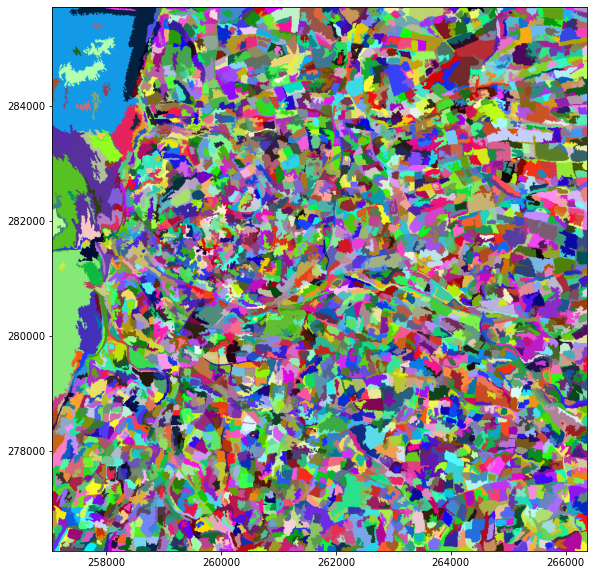

In [16]:
from random import random
input_segs = './sen2_20210527_aber_segs.kea'

# Get the image data as a numpy array and the spatial bounding
# box of the image data. The returned array will be a colour (R,G.B)
# image with the colours from the colour table.
img_data, img_coords, ldg_patches = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(input_segs)#, bands=[1])


# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data, extent=img_coords)#, cmap=new_map, alpha=0.8)

## One-step command

Above we outline all of the steps needed to create a segmented image from an input Sentinel-2 scene. However, to streamline this we also provide a single command that has all of these steps wrapped up in one algorithm. You can call it using:

In [17]:
# All outputs should be KEA files

from rsgislib.segmentation import shepherdseg
import os

input_img = '../data/sen2_20210527_aber.tif'
out_segmentation = './sen2_20210527_aber_segs.kea'
out_mean_img = './sen2_20210527_aber_meanimg.kea'
tmp_dir = './tmp/'
gdalformat = "KEA"

shepherdseg.run_shepherd_segmentation(
    input_img,
    out_segmentation,
    out_mean_img,
    tmp_dir,
    gdalformat,
    calc_stats=True,
    no_stretch=False,
    no_delete=False,
    num_clusters=60,
    min_n_pxls=100,
    dist_thres=100,
    bands=[1,2,3,8,9,10],
    sampling=100,
    km_max_iter=200,
    process_in_mem=True,
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)


Subsetting the image bands
Stretch Input ImageNew image width = 931 height = 947 bands = 6




Band[1] Min = 15 Mean = 48.5252389832 (Std Dev = 19.9321457355) max = 1067
Band[2] Min = 8 Mean = 78.2128592542 (Std Dev = 18.1650242677) max = 1106
Band[3] Min = 11 Mean = 47.7343090729 (Std Dev = 26.2617507701) max = 1111
Band[4] Min = 13 Mean = 448.339837374 (Std Dev = 170.100843825) max = 844
Band[5] Min = 5 Mean = 199.761055603 (Std Dev = 66.6435556283) max = 747
Band[6] Min = 5 Mean = 104.637335154 (Std Dev = 37.8636352173) max = 899
New image width = 931 height = 947 bands = 6

Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.New image width = 931 height = 947 bands = 6

Mask stretched Image.

Image: ./tmp/sen2_20210527_aber_bselect.kea
	 Variable 'b1' is band 1
New image width = 931 height = 947 bands = 1

New image width = 931 height = 947 bands = 6

Deleting file: ./tmp/sen2_20210527_aber_stchdonly.kea
Deleting file: .

Image Data Size: 931 x 947


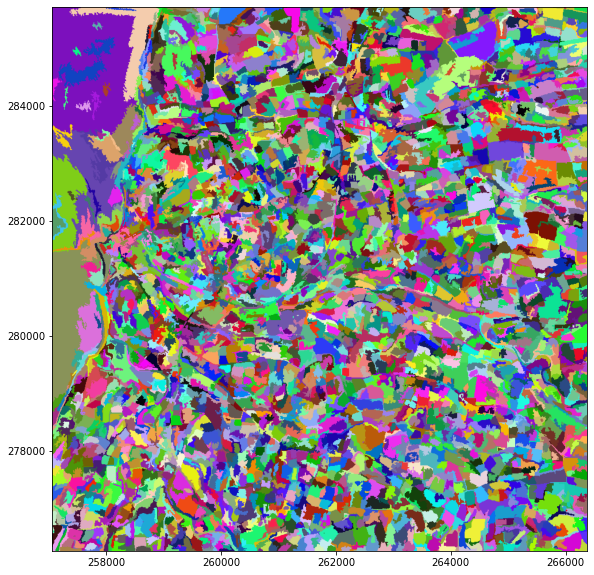

In [18]:
from random import random
input_segs = out_segmentation

# Get the image data as a numpy array and the spatial bounding
# box of the image data. The returned array will be a colour (R,G.B)
# image with the colours from the colour table.
img_data, img_coords, ldg_patches = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(input_segs)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data, extent=img_coords)